In [1]:
import netsquid as ns
import numpy as np
from netsquid.qubits.qubitapi import *
from netsquid.qubits.operators import *
from netsquid.qubits.qformalism import QFormalism
import pandas as pd 
from quantum_tools.quantum_state_utils import generate_parties, generate_probabilities, generate_uni_sample, form_dm, generate_ghz_dm, update_party_indices
from quantum_tools.quantum_operations import generate_anonymous
import os

In [2]:
num_party = 5
sample_probs = 10
num_sample = 1

p, num_qubit = generate_parties(num_party)

probs = generate_probabilities(sample_probs)

message_A = generate_uni_sample(num_sample)
message_B = generate_uni_sample(num_sample)
output_array = np.ndarray(shape=(len(probs), 7), dtype=object)

GHZ_3 = generate_ghz_dm(3)
GHZ_party = generate_ghz_dm(num_party*2)

In [3]:
# Loop over the range of sample probabilities
for j in range(sample_probs):
    # Generate the anonymous state and calculate fidelities and the reduced density matrix
    fidelity_anonymous, fidelity_ghz, dm_matrix = generate_anonymous(probs[j], p, num_party, "depolarize", GHZ_party, GHZ_3)
    
    # Store the current probability value in the output array
    output_array[j][0] = probs[j]
    
    # Store the fidelity of the anonymous state in the output array
    output_array[j][3] = fidelity_anonymous
    
    # Store the fidelity of the GHZ state in the output array
    output_array[j][4] = fidelity_ghz
    
    # Store the reduced density matrix in the output array
    output_array[j][6] = dm_matrix
    

In [4]:
update_party_indices(p)

In [5]:
# Loop over the range of sample probabilities
for j in range(sample_probs):
    # Initialize counters for fidelity calculations
    fidelity_counter_1 = 0
    fidelity_counter_2 = 0
    
    # Loop over the number of samples
    for k in range(num_sample):
        # Set the quantum state formalism to Density Matrix
        ns.set_qstate_formalism(QFormalism.DM)
        
        # Create the required number of qubits
        qubits = ns.qubits.create_qubits(num_qubit)
        
        # Assign the initial state to a subset of qubits based on the density matrix from the output array
        assign_qstate([qubits[p['a1']], qubits[p['b0']], qubits[p['b1']], qubits[p['a2']], qubits[p['a3']], qubits[p['b2']]], output_array[j][6])
        
        # Form the density matrices for message states
        psi_1 = form_dm(message_A[k][0], message_A[k][1])
        psi_2 = form_dm(message_B[k][0], message_B[k][1])
        
        # Assign the message states to specific qubits
        assign_qstate([qubits[p['A1']], qubits[p['A2']]], psi_1)
        assign_qstate([qubits[p['B1']], qubits[p['B2']]], psi_2)

        # Perform CNOT operations
        operate([qubits[p['A1']], qubits[p['a1']]], CNOT)
        operate([qubits[p['B1']], qubits[p['b2']]], CNOT)

        # Apply Hadamard gates to a range of qubits
        for i in range(p['A1'], p['B2'] + 1):
            operate(qubits[i], H)
                
        # Measure the qubits and get the measurement results
        m1, probs1 = ns.qubits.measure(qubits[p['a1']])
        m2, probs2 = ns.qubits.measure(qubits[p['b2']])
        m3, probs3 = ns.qubits.measure(qubits[p['A1']])
        m4, probs4 = ns.qubits.measure(qubits[p['A2']])
        m5, probs5 = ns.qubits.measure(qubits[p['B1']])
        m6, probs6 = ns.qubits.measure(qubits[p['B2']])

        # Apply conditional X operations based on measurement results
        if m1 == 1:
            operate(qubits[p['b0']], X)
            operate(qubits[p['b1']], X)

        if m2 == 1:
            operate(qubits[p['a2']], X)
            operate(qubits[p['a3']], X)

        # Apply conditional Z operations based on the parity of measurement results
        if (m3 + m4) % 2 == 1:
            operate(qubits[p['b0']], Z)

        if (m5 + m6) % 2 == 1:
            operate(qubits[p['a2']], Z)

        # Calculate the reduced density matrices for the anonymous entangled states
        output_state_1 = reduced_dm([qubits[p['b0']], qubits[p['b1']]])
        output_state_2 = reduced_dm([qubits[p['a2']], qubits[p['a3']]])
        
        # Calculate the fidelity of the reduced states with the original message states
        fidelity_1 = ns.qubits.dmutil.dm_fidelity(output_state_1, psi_1, squared=False)
        fidelity_2 = ns.qubits.dmutil.dm_fidelity(output_state_2, psi_2, squared=False)
        
        # Accumulate the fidelities
        fidelity_counter_1 += fidelity_1
        fidelity_counter_2 += fidelity_2
        
    # Calculate the average fidelities and store them in the output array
    output_array[j][1] = fidelity_counter_1 / num_sample
    output_array[j][2] = fidelity_counter_2 / num_sample


  Noise_Param Fidelity_1 Fidelity_2 Fidelity_Anonymous Fidelity_GHZ  \
0         0.0        1.0        1.0                1.0          1.0   
1    0.111111   0.780402   0.775568           0.758465     0.660521   
2    0.222222   0.670758   0.664637           0.626385     0.440998   
3    0.333333   0.613552   0.608098           0.548031     0.299038   
4    0.444444    0.57735   0.573203           0.492078     0.204712   
5    0.555556   0.550101   0.547297           0.446346     0.139489   
6    0.666667   0.528696   0.527055           0.408259     0.093208   
7    0.777778   0.512949   0.512198           0.378839     0.060596   
8    0.888889   0.503268   0.503078           0.360041     0.039379   
9         1.0        0.5   0.500001           0.353553      0.03125   

  Fidelity_Analytic                                     data_anonymous  
0              None  [[(0.25+0j), 0j, 0j, 0j, 0j, 0j, 0j, (0.25+0j)...  
1              None  [[(0.1774905692729767+0j), 0j, 0j, 0j, 0j, 0j,...  

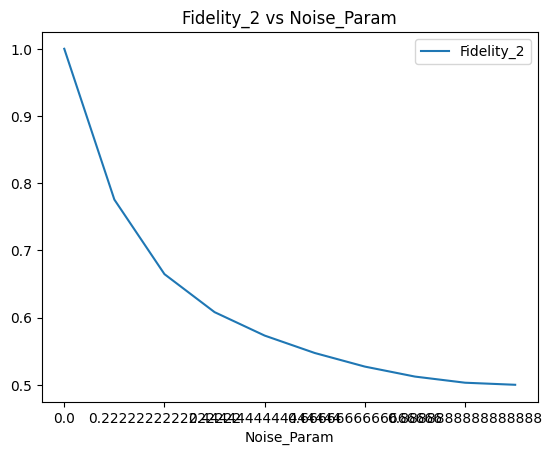

In [7]:
# Create a DataFrame from the output array
fid_data = pd.DataFrame(data=output_array, columns=['Noise_Param', 'Fidelity_1', 'Fidelity_2', 'Fidelity_Anonymous', 'Fidelity_GHZ', 'Fidelity_Analytic', 'data_anonymous'])

# Print the DataFrame
print(fid_data)

# Plot Fidelity_2 against Noise_Param
fid_data.plot(x='Noise_Param', y='Fidelity_2', title='Fidelity_2 vs Noise_Param')

result_folder = 'results'
file_path = os.path.join(result_folder, 'QAD_Fidelity_depolarize_n3_s10000_v1.csv')

# fid_data.to_csv(file_path)